# 1. Setup Notebook

## 1.1. Import Libaries

In [59]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.dates as mdates
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

## 1.2. Import Data

In [47]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 1.3. Setup Function / Modules

In [65]:
def extract_string(column_input):
    if pd.isna(column_input):
        return None
    matches = re.findall(r'\d+\.\d+|\d+', column_input)
    if matches:
        return float(matches[0])
    else:
        return None
    
def remove_outliers_iqr(df, columns_to_check=None, factor=1.5):
    if columns_to_check is None:
        columns_to_check = df.columns

    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    mask = ~((df[columns_to_check] < (Q1 - factor * IQR)) | (df[columns_to_check] > (Q3 + factor * IQR))).any(axis=1)

    df_filtered = df[mask]

    return df_filtered

def plotTimeSeries(dataset, feature_name):
    _ = plt.rcParams['figure.figsize'] = (15, 5)
    _ = plt.grid(which = 'major', c = '#cccccc', alpha = 0.5)
    _ = plt.scatter(dataset.index, dataset[feature_name],
                    marker = 'o', s = 0.1, alpha = 0.5,
                    color = 'blue')
    _ = plt.title(feature_name, family = 'Arial', fontsize = 16)
    _ = plt.xlabel('Timestamp [Date Time]', family = 'Arial', fontsize = 14)
    _ = plt.ylabel(feature_name, family = 'Arial', fontsize = 14)
    _ = plt.xticks(fontsize = 14)
    _ = plt.yticks(fontsize = 14)
    _ = plt.show()
                  
    return None

# 2. Data Pre-Processing

## 2.1. View Data

In [29]:
train.head(5)

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datetime      341880 non-null  int64 
 1   datetime_iso  341880 non-null  object
 2   time-zone     341880 non-null  int64 
 3   temp          341880 non-null  object
 4   visibility    51112 non-null   object
 5   d_point       341880 non-null  object
 6   feels         341880 non-null  object
 7   min_temp      341880 non-null  object
 8   max_temp      341880 non-null  object
 9   prssr         341880 non-null  object
 10  sea_level     192964 non-null  object
 11  grnd_level    192919 non-null  object
 12  hum           341880 non-null  object
 13  wind_spd      341880 non-null  object
 14  wind_deg      341880 non-null  object
 15  rain_1h       341880 non-null  object
 16  rain_3h       192329 non-null  object
 17  snow_1h       192696 non-null  object
 18  snow_3h       192699 non

## 2.2. Extract String

In [48]:
columns_to_extract = ['temp', 'min_temp', 'max_temp', 
                      'prssr', 'hum', 'wind_spd', 
                      'rain_1h', 'rain_3h', 'snow_1h', 
                      'snow_3h', 'clouds', 'd_point', 
                      'feels', 'wind_deg']

for column in columns_to_extract:
    train[column] = train[column].apply(lambda x: extract_string(x))


In [49]:
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,unidentified,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


## 2.3. Convert `datetime_iso` To Datetime

In [50]:
train['datetime_iso'] = pd.to_datetime(train['datetime_iso'], format='%Y-%m-%d %H:%M:%S%z')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   datetime      341880 non-null  int64              
 1   datetime_iso  341880 non-null  datetime64[ns, UTC]
 2   time-zone     341880 non-null  int64              
 3   temp          341880 non-null  float64            
 4   visibility    51112 non-null   object             
 5   d_point       341880 non-null  float64            
 6   feels         341880 non-null  float64            
 7   min_temp      341880 non-null  float64            
 8   max_temp      341880 non-null  float64            
 9   prssr         341880 non-null  float64            
 10  sea_level     192964 non-null  object             
 11  grnd_level    192919 non-null  object             
 12  hum           341880 non-null  float64            
 13  wind_spd      341880 non-null  float64      

In [34]:
train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,unidentified,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


## 2.4. Drop Unnecessary Column

In [51]:
train.apply(pd.isnull).sum()/train.shape[0]

datetime        0.000000
datetime_iso    0.000000
time-zone       0.000000
temp            0.000000
visibility      0.850497
d_point         0.000000
feels           0.000000
min_temp        0.000000
max_temp        0.000000
prssr           0.000000
sea_level       0.435580
grnd_level      0.435711
hum             0.000000
wind_spd        0.000000
wind_deg        0.000000
rain_1h         0.077799
rain_3h         0.545963
snow_1h         0.513040
snow_3h         0.523189
clouds          0.000000
dtype: float64

In [72]:
train_df = train.drop(['datetime', 'time-zone', 'visibility',
            'sea_level','grnd_level'], axis=1)
train_df.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


In [73]:
train_df = train_df.set_index('datetime_iso')
train_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
datetime_iso,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0


In [74]:
train_df.isna().sum()

temp             0
d_point          0
feels            0
min_temp         0
max_temp         0
prssr            0
hum              0
wind_spd         0
wind_deg         0
rain_1h      26598
rain_3h     186654
snow_1h     175398
snow_3h     178868
clouds           0
dtype: int64

In [75]:
train_df['rain_1h'] = train_df['rain_1h'].fillna(train_df['rain_1h'].mean())
train_df.isna().sum()

temp             0
d_point          0
feels            0
min_temp         0
max_temp         0
prssr            0
hum              0
wind_spd         0
wind_deg         0
rain_1h          0
rain_3h     186654
snow_1h     175398
snow_3h     178868
clouds           0
dtype: int64

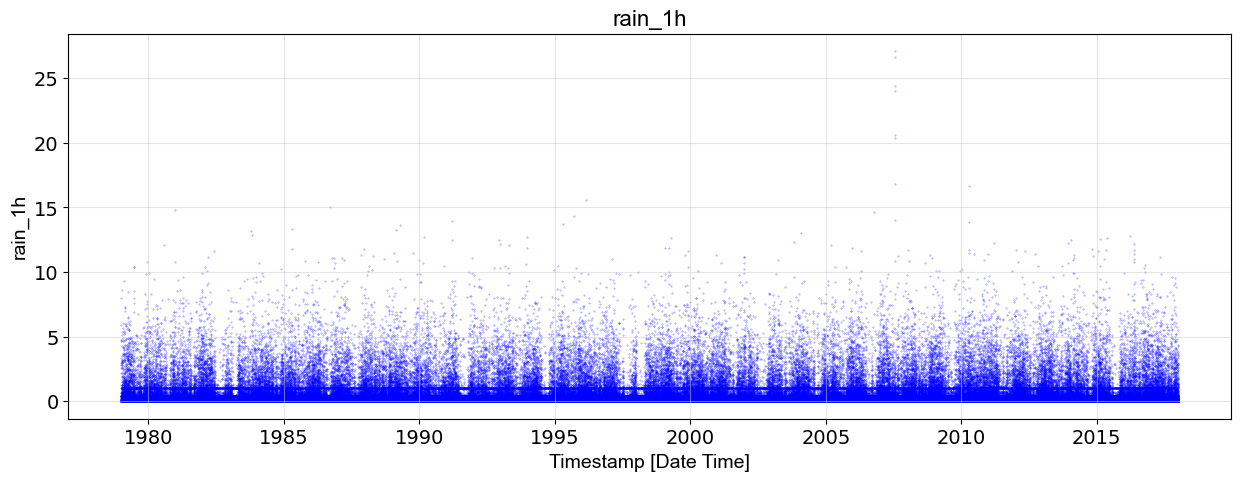

In [77]:
plotTimeSeries(train_df, 'rain_1h')

In [16]:
# train_df['delta_temp'] = train_df['temp'] - train_df['d_point']
# train_df['relative_humadity'] = (1- (train_df['d_point'] / train_df['temp'])) * 100
# train2['combined_weather_feature'] = train2['temp'] * train2['relative_humadity'] * train2['clouds']

In [17]:
train_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
datetime_iso,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,0.0,NaN,NaN,100.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,0.0,0.0,0.0,100.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,NaN,NaN,NaN,99.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,NaN,0.0,NaN,94.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,NaN,NaN,0.0,100.0


In [78]:
train2 = train_df.drop(['rain_3h','snow_1h','snow_3h'], axis = 1)

In [79]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 341880 entries, 1979-01-01 00:00:00+00:00 to 2017-12-31 23:00:00+00:00
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   temp      341880 non-null  float64
 1   d_point   341880 non-null  float64
 2   feels     341880 non-null  float64
 3   min_temp  341880 non-null  float64
 4   max_temp  341880 non-null  float64
 5   prssr     341880 non-null  float64
 6   hum       341880 non-null  float64
 7   wind_spd  341880 non-null  float64
 8   wind_deg  341880 non-null  float64
 9   rain_1h   341880 non-null  float64
 10  clouds    341880 non-null  float64
dtypes: float64(11)
memory usage: 31.3 MB


In [80]:
train2.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
datetime_iso,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0


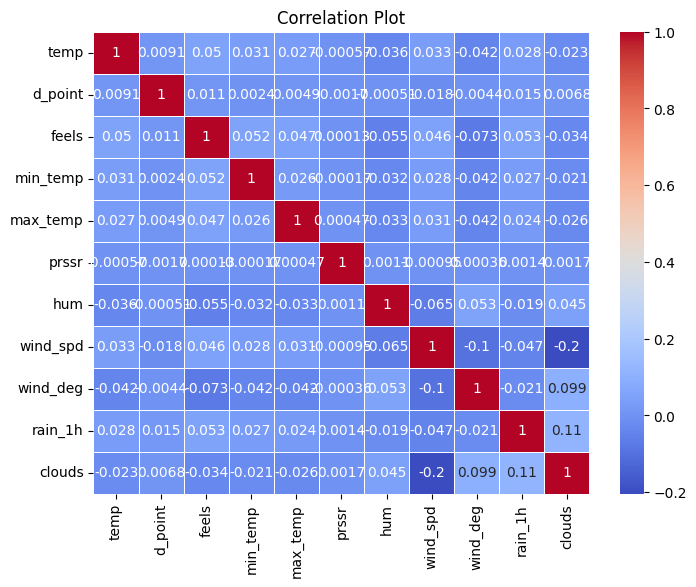

In [21]:
# Calculate the correlation matrix
correlation_matrix = train2.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [221]:
def degrees_to_direction(degrees):
    directions = [
        ("N", (0.00, 22.5)),
        ("NNE", (22.5, 45)),
        ("NE", (45, 67.5)),
        ("ENE", (67.5, 90)),
        ("E", (90, 112.5)),
        ("ESE", (112.5, 135)),
        ("SE", (135, 157.5)),
        ("SSE", (157.5, 180)),
        ("S", (180, 202.5)),
        ("SSW", (202.5, 225)),
        ("SW", (225, 247.5)),
        ("WSW", (247.5, 270)),
        ("W", (270, 292.5)),
        ("WNW", (292.5, 315)),
        ("NW", (315, 337.5)),
        ("NNW", (337.5, 360.0))
    ]
    
    for direction, (lower, upper) in directions:
        if lower <= degrees <= upper:
            return direction
    
    return "N/A"

In [232]:
train2['wind_direction'] = train2['wind_deg'].apply(degrees_to_direction)
train2.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds,wind_direction,wind_direction_encoded
datetime_iso,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0,NW,14.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0,NNW,15.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0,NNW,15.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0,NNW,15.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0,NW,14.0


In [233]:
wind_direction_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,  # Corrected 'EAE' to 'ESE' based on your previous direction categories
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

train2['wind_direction_encoded'] = train2['wind_direction'].map(wind_direction_mapping)

In [182]:
train2.sample(10)

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds,wind_direction,wind_direction_encoded
datetime_iso,,,,,,,,,,,,,
1987-09-09 17:00:00+00:00,24.53,23.68,25.52,23.48,25.93,1010.0,95.0,2.31,1031.15,0.401359,94.0,N/A,NaN
1987-07-09 00:00:00+00:00,24.82,23.96,25.84,24.28,25.34,1013.0,95.0,2.19,201.00,0.000000,65.0,S,8.0
2012-05-31 17:00:00+00:00,25.62,25.11,26.77,25.02,26.16,1009.0,97.0,1.74,201.00,0.000000,99.0,S,8.0
2015-05-08 14:00:00+00:00,27.57,25.59,32.27,26.67,28.86,1010.0,89.0,0.95,217.00,0.000000,80.0,SSW,9.0
1981-06-03 23:00:00+00:00,25.21,24.70,26.32,24.72,26.06,1011.0,97.0,1.20,258.00,0.000000,44.0,WSW,11.0
1989-09-11 23:00:00+00:00,24.42,23.21,25.35,23.75,25.73,1010.0,93.0,2.12,216.00,0.000000,90.0,SSW,9.0
2007-06-01 23:00:00+00:00,26.08,25.04,26.08,25.61,26.56,1010.0,94.0,0.84,254.00,0.000000,95.0,WSW,11.0
2007-03-05 21:00:00+00:00,25.17,24.31,26.22,24.56,25.83,1008.0,95.0,1.42,351.00,0.000000,97.0,NNW,15.0
1987-12-23 12:00:00+00:00,27.58,25.22,32.01,26.72,28.26,1010.0,87.0,1.67,77.00,0.940000,89.0,ENE,3.0


In [185]:
train_clean = train2.dropna()

In [234]:
train_clean.isna().sum()

temp                        0
d_point                     0
feels                       0
min_temp                    0
max_temp                    0
prssr                       0
hum                         0
wind_spd                    0
wind_deg                    0
rain_1h                     0
clouds                      0
wind_direction              0
wind_direction_encoded      0
delta_temp                  0
relative_humidity           0
combined_weather_feature    0
dtype: int64

In [187]:
train_clean['delta_temp'] = train_clean['temp'] - train_clean['d_point']
train_clean['relative_humidity'] = (1- (train_clean['d_point'] / train_clean['temp'])) * 100
train_clean['combined_weather_feature'] = train_clean['temp'] * train_clean['relative_humidity'] * train_clean['clouds']

C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_19312\2746570774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['delta_temp'] = train_clean['temp'] - train_clean['d_point']
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_19312\2746570774.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_clean['relative_humidity'] = (1- (train_clean['d_point'] / train_clean['temp'])) * 100
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_19312\2746570774.py:3: SettingWithCopyWarning: 
A value is trying t

In [188]:
train_clean.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds,wind_direction,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
datetime_iso,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0,NW,14.0,0.86,3.474747,8600.0
1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0,NNW,15.0,0.85,3.458096,8500.0
1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0,NNW,15.0,2.54,9.548872,25146.0
1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0,NNW,15.0,2.94,10.765287,27636.0
1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0,NW,14.0,2.36,8.609996,23600.0


In [195]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
train_scaled = scaler.fit_transform(train_clean.drop('wind_direction', axis = 1))
scaled_df = pd.DataFrame(train_scaled, columns=train_clean.drop('wind_direction', axis = 1).columns)
scaled_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
0,0.020551,0.077803,0.018907,0.068280,0.017294,0.002673,0.139241,0.032413,0.891365,0.014810,1.00,0.933333,0.421689,0.827321,0.440644
1,0.019459,0.076549,0.017853,0.066331,0.017536,0.002673,0.139241,0.038015,0.941504,0.000000,1.00,1.000000,0.421651,0.827287,0.440604
2,0.032432,0.079135,0.023564,0.080511,0.030461,0.002673,0.120253,0.048419,0.944290,0.000000,0.99,1.000000,0.428032,0.839683,0.447287
3,0.036992,0.081564,0.047405,0.083804,0.036347,0.002673,0.116034,0.042817,0.952646,0.004797,0.94,1.000000,0.429542,0.842159,0.448286
4,0.037634,0.086892,0.050954,0.083737,0.036044,0.002430,0.122363,0.034014,0.935933,0.012546,1.00,0.933333,0.427352,0.837772,0.446666


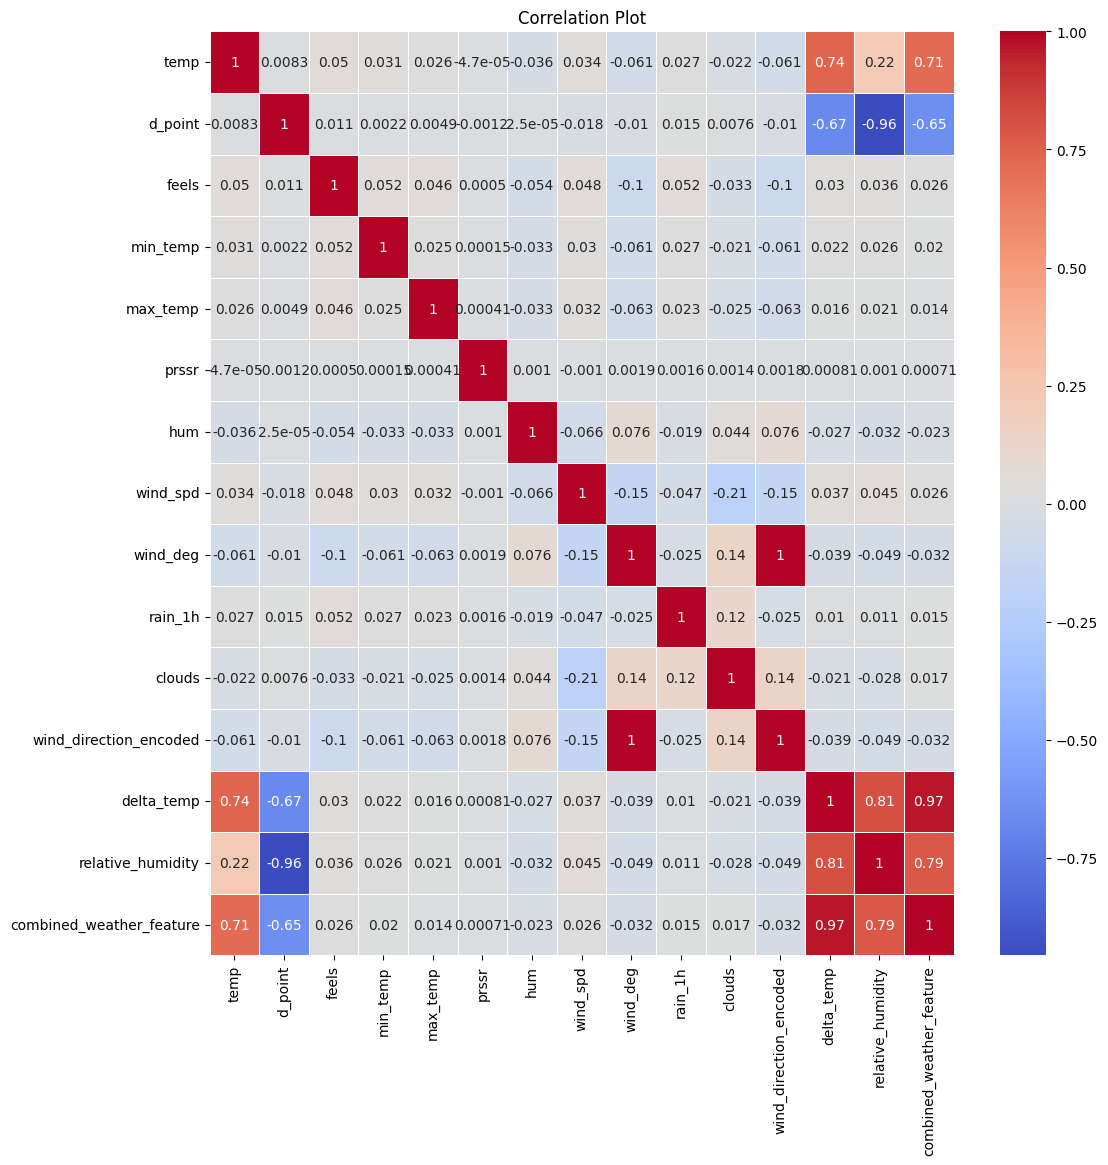

In [196]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [197]:
from sklearn.model_selection import train_test_split
X = scaled_df.drop('rain_1h', axis = 1)
y = scaled_df['rain_1h']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [198]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=0, max_features = "sqrt")

# Fit the model to the data
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: ", rmse)

RMSE:  0.03199261173106328


In [199]:
test.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds
0,1514764800,2018-01-01 00:00:00+00:00,28800,26.59 °C,NaN,23.66,26.59,26.02,27.16,1009,NaN,undetermined,84,1.45 m/s,355,0,NaN,no_snow,97
1,1514768400,2018-01-01 01:00:00+00:00,28800,26.51 C,NaN,24.92,26.51 °C,26.06,28.04,1009,NaN,undetermined,91,1.67 m/s,351,0mm,no-snow,0 milimeter,95
2,1514772000,2018-01-01 02:00:00+00:00,28800,28.68 C,NaN,25.71,34.68,28.03 C,29.3 C,1009.0 hPa.,NaN,NaN,84,1.72 m/s,345.0°,0 mm,volume:zero,0,90
3,1514775600,2018-01-01 03:00:00+00:00,28800,28.84 C,NaN,25.25,34.51,28.52,29.08 °C,1008,NaN,NaN,81,1.49,339.0°,0 milimeter,0,NaN,91
4,1514779200,2018-01-01 04:00:00+00:00,28800,29.75 Celcius,,24.62,35.38,29.31 C,30.57,1007,undetermined,undetermined,74,1.39 m/s,339.0°,NaN,0,volume:0,96


In [201]:
columns_to_extract = ['temp', 'min_temp', 'max_temp', 
                      'prssr', 'hum', 'wind_spd', 
                      'rain_3h', 'snow_1h', 
                      'snow_3h', 'clouds', 'd_point', 
                      'feels', 'wind_deg']

for column in columns_to_extract:
    test[column] = test[column].apply(lambda x: extract_string(x))


In [202]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datetime      49368 non-null  int64  
 1   datetime_iso  49368 non-null  object 
 2   time-zone     49368 non-null  int64  
 3   temp          49368 non-null  float64
 4   visibility    7533 non-null   object 
 5   d_point       49367 non-null  float64
 6   feels         49368 non-null  float64
 7   min_temp      49368 non-null  float64
 8   max_temp      49368 non-null  float64
 9   prssr         49368 non-null  float64
 10  sea_level     27694 non-null  object 
 11  grnd_level    27866 non-null  object 
 12  hum           49368 non-null  float64
 13  wind_spd      49368 non-null  float64
 14  wind_deg      49368 non-null  float64
 15  rain_3h       22459 non-null  float64
 16  snow_1h       23912 non-null  float64
 17  snow_3h       23556 non-null  float64
 18  clouds        49368 non-nu

In [203]:
test.isna().sum()

datetime            0
datetime_iso        0
time-zone           0
temp                0
visibility      41835
d_point             1
feels               0
min_temp            0
max_temp            0
prssr               0
sea_level       21674
grnd_level      21502
hum                 0
wind_spd            0
wind_deg            0
rain_3h         26909
snow_1h         25456
snow_3h         25812
clouds              0
dtype: int64

In [206]:
test2 = test.drop(['visibility','rain_3h','snow_1h','snow_3h','sea_level','grnd_level', 'datetime', 'time-zone'], axis = 1)

In [208]:
test2.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [235]:
test2['wind_direction'] = test2['wind_deg'].apply(degrees_to_direction)
test2.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_direction,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0,NNW,15.0,2.93,11.019180,28421.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0,NNW,15.0,1.59,5.997737,15105.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0,NNW,15.0,2.97,10.355649,26730.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0,NNW,15.0,3.59,12.447989,32669.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0,NNW,15.0,5.13,17.243697,49248.0


In [236]:
test2['wind_direction_encoded'] = test2['wind_direction'].map(wind_direction_mapping)

In [224]:
test2.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_direction,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0,NNW,15.0,2.93,11.019180,28421.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0,NNW,15.0,1.59,5.997737,15105.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0,NNW,15.0,2.97,10.355649,26730.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0,NNW,15.0,3.59,12.447989,32669.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0,NNW,15.0,5.13,17.243697,49248.0


In [225]:
test2['delta_temp'] = test2['temp'] - test2['d_point']
test2['relative_humidity'] = (1- (test2['d_point'] / test2['temp'])) * 100
test2['combined_weather_feature'] = test2['temp'] * test2['relative_humidity'] * test2['clouds']

In [229]:
filtered_rows = test2['wind_deg'].notna() & test2['wind_direction_encoded'].isna()
filtered_data = test2[filtered_rows]

In [230]:
filtered_data

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_direction,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
34,2018-01-02 10:00:00+00:00,29.23,27.23,36.23,28.02,29.90,1005.0,89.0,0.23,125.0,93.0,ESE,NaN,2.00,6.842285,18600.0
370,2018-01-16 10:00:00+00:00,26.92,24.57,30.21,26.22,30.04,1006.0,87.0,0.98,126.0,99.0,ESE,NaN,2.35,8.729569,23265.0
515,2018-01-22 11:00:00+00:00,28.52,26.91,35.52,28.23,29.04,1006.0,91.0,0.97,114.0,100.0,ESE,NaN,1.61,5.645161,16100.0
516,2018-01-22 12:00:00+00:00,28.16,26.17,34.07,27.14,28.71,1007.0,89.0,1.15,116.0,100.0,ESE,NaN,1.99,7.066761,19900.0
585,2018-01-25 09:00:00+00:00,29.83,27.43,36.83,29.33,30.12,1004.0,87.0,0.57,113.0,83.0,ESE,NaN,2.40,8.045592,19920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49326,2023-08-18 06:00:00+00:00,29.53,20.12,31.44,27.84,30.64,1009.0,57.0,4.07,132.0,31.0,ESE,NaN,9.41,31.865899,29171.0
49327,2023-08-18 07:00:00+00:00,29.59,20.17,31.55,27.84,31.04,1009.0,57.0,4.07,132.0,31.0,ESE,NaN,9.42,31.835079,29202.0
49352,2023-08-19 08:00:00+00:00,28.81,22.55,32.14,28.00,30.04,1008.0,69.0,3.01,113.0,86.0,ESE,NaN,6.26,21.728566,53836.0
49353,2023-08-19 09:00:00+00:00,28.75,22.50,32.02,28.00,29.63,1008.0,69.0,3.01,113.0,86.0,ESE,NaN,6.25,21.739130,53750.0


In [237]:
test2.isna().sum()

datetime_iso                0
temp                        0
d_point                     1
feels                       0
min_temp                    0
max_temp                    0
prssr                       0
hum                         0
wind_spd                    0
wind_deg                    0
clouds                      0
wind_direction              0
wind_direction_encoded      0
delta_temp                  1
relative_humidity           1
combined_weather_feature    1
dtype: int64

In [242]:
test_clean = test2.fillna(test2.drop(['datetime_iso', 'wind_direction'],axis=1).mean())

In [243]:
test_clean.isna().sum()

datetime_iso                0
temp                        0
d_point                     0
feels                       0
min_temp                    0
max_temp                    0
prssr                       0
hum                         0
wind_spd                    0
wind_deg                    0
clouds                      0
wind_direction              0
wind_direction_encoded      0
delta_temp                  0
relative_humidity           0
combined_weather_feature    0
dtype: int64

In [244]:
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range= (0,1))
test_scaled = scaler.fit_transform(test_clean.drop(['datetime_iso','wind_direction'], axis = 1))
scaled_test = pd.DataFrame(test_scaled, columns=test_clean.drop(['datetime_iso','wind_direction'], axis = 1).columns)
scaled_test.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_direction_encoded,delta_temp,relative_humidity,combined_weather_feature
0,0.000415,0.453057,0.000325,0.000599,0.015764,0.992358,0.84,0.000145,0.986111,0.97,1.0,0.226255,0.293221,0.232959
1,0.000407,0.590611,0.000317,0.000603,0.019285,0.992358,0.91,0.000167,0.975000,0.95,1.0,0.122780,0.159600,0.123811
2,0.000624,0.676856,0.001135,0.000801,0.024327,0.992358,0.84,0.000172,0.958333,0.90,1.0,0.229344,0.275564,0.219098
3,0.000641,0.626638,0.001118,0.000850,0.023447,0.991266,0.81,0.000149,0.941667,0.91,1.0,0.277220,0.331241,0.267779
4,0.000732,0.557860,0.001205,0.000929,0.029408,0.990175,0.74,0.000139,0.941667,0.96,1.0,0.396139,0.458855,0.403672


In [246]:
predictions = rf_model.predict(scaled_test)

In [247]:
predictions

array([0.02389851, 0.02490001, 0.02141074, ..., 0.02569337, 0.02569337,
       0.02125157])

In [248]:
submission = pd.DataFrame({
    'datetime_iso': test_clean['datetime_iso'],
    'rain_1h': predictions
})

submission.to_csv('data/sample_submission.csv', index=False)